In [39]:
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt

In [40]:
(trainX, trainy), (testX, testy) = load_data()

In [41]:
testX.shape

(10000, 32, 32, 3)

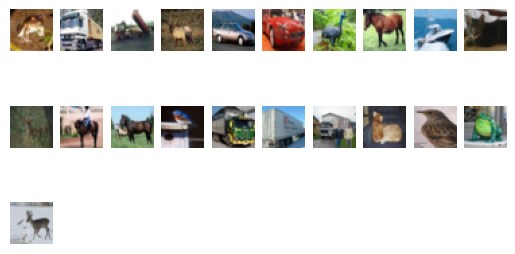

In [42]:
# explore images

for image in range(21):
    plt.subplot(4,10,image+1)
    plt.axis('off')
    plt.imshow(trainX[image])

plt.show()

# Discriminator Architecture

In [44]:
import numpy

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Conv2D, Flatten, LeakyReLU
#from tensorflow.keras.utils import plot_model
#from keras.utils.vis_utils import plot_model #visualise architecture
from keras.utils import plot_model

* In GANs LeakyReLU works better than ReLU

In [45]:
# Discriminator
def define_discriminator(in_shape=(32,32,3)):
    
    model = Sequential()
    model.add(Conv2D(64,(3,3), padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsampling (using strides not max-pooling) --> proven that strides works well in case of Discriminator
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsampling (using strides)
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsampling (using strides)
    model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #classifier
    model.add(Flatten())
    model.add(Dropout(0.4)) #half nodes got closed
    model.add(Dense(1,activation='sigmoid')) # output near to 1 means image is real
    
    #compile model
    optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

64 --> filters, (3,3) --> filter size

In [46]:
#model call 
model = define_discriminator()
model.summary()

plot_model(model,to_file='discirminator.png',show_shapes=True,show_layer_names=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 4, 256)        

* We have made the discriminator architecture
* We have to train it --> to see how training happens
* discriminator will get two types of data
    * Original CIFAR data
    * Random fake data
* we have tell the discriminator which is original and which is fake data(noise)
* after this we have to see accuracy of the discriminator

`Preparing a setup to do above task of feeding discriminator with noise and original data`

In [47]:
#loading and scalling dataset - preparing dataset [Real Data] label - 1

def load_real_samples():
    (trainX,_),(_,_) = load_data()
    
    #convert from unsigned ints to floats -- suggested to increase compatibility issue with algorithm
    X = trainX.astype('float32')
    
    #scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [48]:
# total number of real images
X = load_real_samples()
X.shape

(50000, 32, 32, 3)

In [49]:
# First image -- all value must be in range of (-1,1)
X[0]

array([[[-0.5372549 , -0.5137255 , -0.5058824 ],
        [-0.6627451 , -0.6392157 , -0.64705884],
        [-0.60784316, -0.62352943, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215687, -0.01960784, -0.2       ],
        [ 0.16078432, -0.02745098, -0.19215687]],

       [[-0.8745098 , -0.84313726, -0.84313726],
        [-1.        , -1.        , -1.        ],
        [-0.85882354, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980393, -0.5686275 ],
        [-0.06666667, -0.34901962, -0.60784316],
        [-0.04313726, -0.31764707, -0.5529412 ]],

       [[-0.8039216 , -0.8117647 , -0.8352941 ],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.6156863 , -0.7882353 , -0.9372549 ],
        ...,
        [-0.07450981, -0.34117648, -0.60784316],
        [-0.05882353, -0.34117648, -0.60784316],
        [-0.14509805, -0.42745098, -0.67058825]],

       ...,

       [[ 0.6313726 ,  0.33333334, -0.24705882],
        [ 0

* will not provide 50k images at once
    * we will feed in image using batches
    * in our case making batch size of 128
        * 64 Real and 64 Fake images
    * after going through each batch it will update weights

In [50]:
# random real data point collection
import numpy as np

def generate_real_samples(dataset,n_samples):
    
    #choosing random instance
    ix = np.random.randint(0, dataset.shape[0],n_samples)
    
    #get selected images
    X = dataset[ix]
    
    #real class labels generation - 1
    y = np.ones((n_samples,1))
    return X,y

In [51]:
# all 64 real images, here y will be all real images labelled as 1
X,y = generate_real_samples(dataset=X,n_samples=64)
print(X.shape,y.shape)

(64, 32, 32, 3) (64, 1)


In [52]:
# random fake data point collection | we are doing in manually but it is valide only when done by Generator

def generate_fake_samples(n_samples):
    
    #generation of uniform random numbers in [0,1]
    X = np.random.rand(32*32*3*n_samples) #numpy array - noise data of images
    ##scaling range [-1,1]
    X = -1 + X * 2
    #reshape into a batch of images
    X = X.reshape((n_samples,32,32,3))
    
    #fake class labels generate - 0
    y = np.zeros((n_samples,1))
    return X,y

In [53]:
# here all y will be 0 - fake images
X,y = generate_fake_samples(64)
print(X.shape,y.shape)

(64, 32, 32, 3) (64, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


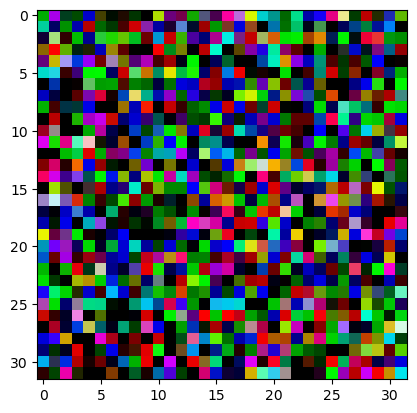

In [54]:
# this is how noise looks like
plt.imshow(X[0])
plt.show()

In [55]:
# training discriminator tempo way

def train_discriminator(model,dataset,n_iter=15,n_batch=128):
    half_batch = int(n_batch/2) # 2 bathes --> 64 real, 64 noise
    
    #manual enumerate epochs
    for i in range(n_iter):
        #get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset,half_batch)
        #update discriminator on real samples  --> updating weights and saving accuracy
        _, real_acc = model.train_on_batch(X_real,y_real)
        
        #generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        #update discriminator on fake samples  --> updating weights and saving accuracy
        _, fake_acc = model.train_on_batch(X_fake,y_fake)
        
        #summarize performance
        print(f"{i+1}, Real = {real_acc*100}, Fake = {fake_acc*100}")

* It was seen in experimentation that mixing fake and real data was not producing better result then giving batches(noise,real [not mixed]) and then updating weights

In [56]:
# Dummy Training

# descriminator model def
model = define_discriminator()

#load image data
dataset = load_real_samples()

#fit model
train_discriminator(model,dataset)

1, Real = 7.8125, Fake = 26.5625
2, Real = 85.9375, Fake = 39.0625
3, Real = 84.375, Fake = 68.75
4, Real = 85.9375, Fake = 93.75
5, Real = 84.375, Fake = 100.0
6, Real = 76.5625, Fake = 100.0
7, Real = 76.5625, Fake = 100.0
8, Real = 87.5, Fake = 100.0
9, Real = 87.5, Fake = 100.0
10, Real = 89.0625, Fake = 100.0
11, Real = 100.0, Fake = 100.0
12, Real = 100.0, Fake = 100.0
13, Real = 93.75, Fake = 100.0
14, Real = 100.0, Fake = 100.0
15, Real = 98.4375, Fake = 100.0


Above see Fake and Real accur, ---> Simple classification

# Generator Architecture

In [58]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from keras.utils import plot_model
#from keras.utils.vis_utils import plot_model

`Conv2DTranspose` --> used for upscallig

----

* It take noise image as an input
    * In our case input noise will be a randomly generated 100 dimention vector from a Gausian Dist  | there will be multiple of them in input
    * This noise is called `Laten Variable`
* Generator will give output image of shape --> `(32 * 32 * 3)`

In [59]:
# defining generator 
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256*4*4 #4096
    
    model.add(Dense(n_nodes,input_dim=latent_dim)) #in generator first layer is dense layer
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256))) # 256 images(to capture all representation of real data) of size 4*4 [small shape is decide with experimentations, then will be increased] 
    
    #upsample (8*8)
    model.add(Conv2DTranspose(128,(4*4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #upsample (16*16)
    model.add(Conv2DTranspose(128,(4*4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #upsample (32*32) --> required shape
    model.add(Conv2DTranspose(128,(4*4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #output layer
    model.add(Conv2D(3, (3,3), activation='tanh',padding='same')) #32*32*3
    return model

In [60]:
#say size of latent space - as this is noise other number can be taken
latent_dim = 100

#generator model
model = define_generator(latent_dim)

#model summary
model.summary()

#ploting model
plot_model(model,to_file='generator.png', show_shapes=True,show_layer_names=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         8388736   
 anspose)                                                        
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       4194432   
 Transpose)                                           

`Generator` is not trained yet as it is not getting any feedback from the `Descriminator`
* see architecture of generator is ready

----

`Generator` have generally two tasks to do:
1. Give image to Descriminator and Descriminator will also get data from Generator
2. Self improvement

In [61]:
#generate points in latent space as input for generator
def generate_latent_points(latent_dim,n_samples): #(no_of_cols,no_of_rows) or (this_dimensio's,this number of image)
    #generatng points in latent space
    x_input = np.random.randn(latent_dim * n_samples)
    #reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [62]:
x_input = generate_latent_points(100,64) #giving generator 64, 100 dimentional points ## generator will give 64, 32*32*3 dimentional image
print(x_input.shape) # mix this fake/noise data with real data and pump into Disctriminator

(64, 100)


In [63]:
#use the generator to generate n fake samples, with class labels
def generate_fake_samples(g_model,latent_dim,n_samples): #(n_samples = number of photos)
    #generate points in latent space
    x_input = generate_latent_points(latent_dim,n_samples)
    #predict outputs
    X = g_model.predict(x_input)
    #creat 'fake' class labels (0)
    y = np.zeros((n_samples,1))
    return X,y

2/2 [==============================] - 5s 2s/step


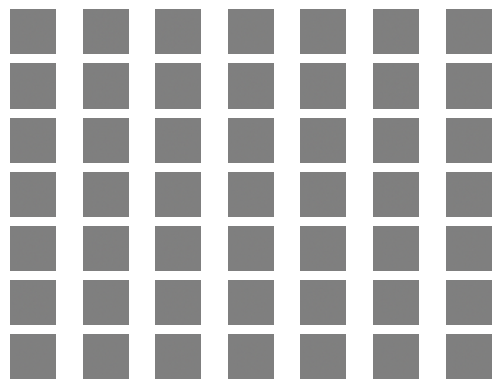

In [64]:
### testing above functions ### |Lets see what kind of images Generator is producing

# latent space size
latent_dim = 100

#define generator model
model = define_generator(latent_dim)
#generate samples
n_samples = 49
X, _ = generate_fake_samples(model,latent_dim,n_samples)

#scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0

#plot generated samples
for i in range(n_samples):
    #define subplot
    plt.subplot(7,7,1+i)
    #turn off axis labels
    plt.axis('off')
    #plot single image
    plt.imshow(X[i])
plt.show()

These image produced by Generator are gray one, while zooming into images there will be some noise
* This is happning case at this time generator is not trained i.e. have not take any feadback from Discriminator

## Combinig Generator and Distriminator to make a GAN

In [65]:
### making combined generator and discriminator model, for updating generator ####
def define_gan(g_model,d_model): #(geenrator,descriminator)
    #make weights in discriminator un-trainable | in back prop only weights of Generater will be updated
    d_model.trainable = False 
    #connect them
    model = Sequential()
    #add generator
    model.add(g_model)
    #add discriminator
    model.add(d_model)
    #compile model
    opt = Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

In [66]:
#latent space size
latent_dim = 100

#creating a discriminator
d_model = define_discriminator()
#creating generator
g_model = define_generator(latent_dim)

#creating GAN
gan_model = define_gan(g_model, d_model)

#summarizing gan model
gan_model.summary()

#ploting GAN
plot_model(gan_model, to_file='gen.png',show_shapes=True,show_layer_names=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 32, 32, 3)         17194755  
                                                                 
 sequential_8 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 17717252 (67.59 MB)
Trainable params: 17194755 (65.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### Training Generator and Discriminator 

In [67]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=20,n_batch=10): # epochs=100, n_batch=128
    bat_per_epo = int(dataset.shape[0] / n_batch) #rows_in_dataset divided by batch_size [50000/128 = ~390 batches/epoch]
    half_batch = int(n_batch / 2)
    
    #manually enumerate epochs
    for i in range(n_epochs):
        
        for j in range(bat_per_epo):
            #getting randomly selected "real" samples
            X_real, y_real = generate_real_samples(dataset,half_batch)
            #updating discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real,y_real)
            
            #generating "fake" examples
            X_fake, y_fake = generate_fake_samples(g_model,latent_dim,half_batch) # ouptu = 64(images),0(image label as fake)
            #updating discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake,y_fake)
            
            #preparing points in latent space as input for generator
            X_gan = generate_latent_points(latent_dim,n_batch) #generating input images
            #creating inverted labels for the fake samples
            y_gan = np.ones((n_batch,1)) #in composit model all images getting from generator must be shown as real image
            
            #updating "generator via the discriminator's error"
            g_loss = gan_model.train_on_batch(X_gan,y_gan)
            
            #summarizing loss on this batch
            print(f"Epoch: {i+1}, Batch inside Epoch: {j+1}, Total batches: {bat_per_epo}, dis_loss_realData: {d_loss1}, dis_loss_fakeData: {d_loss2}, gan_composit_model_loss: {g_loss}")
            
            #evaluating model performance
            if (i+1) % 10 == 0:
                summarize_performance(i,g_model,d_model,dataset,latent_dim) # i = number of epoch

In [ ]:
train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=20,n_batch=10)

1/1 [==============================] - 1s 740ms/step
Epoch: 1, Batch inside Epoch: 1, Total batches: 5000, dis_loss_realData: 0.6928709745407104, dis_loss_fakeData: 0.6950538158416748, gan_composit_model_loss: 0.6920310258865356
1/1 [==============================] - 1s 517ms/step
Epoch: 1, Batch inside Epoch: 2, Total batches: 5000, dis_loss_realData: 0.6418838500976562, dis_loss_fakeData: 0.7008252143859863, gan_composit_model_loss: 0.6870893239974976
1/1 [==============================] - 1s 511ms/step
Epoch: 1, Batch inside Epoch: 3, Total batches: 5000, dis_loss_realData: 0.5797287225723267, dis_loss_fakeData: 0.7534022331237793, gan_composit_model_loss: 0.6481657028198242
1/1 [==============================] - 1s 540ms/step
Epoch: 1, Batch inside Epoch: 4, Total batches: 5000, dis_loss_realData: 0.5253530740737915, dis_loss_fakeData: 0.9466487765312195, gan_composit_model_loss: 0.6039087176322937
1/1 [==============================] - 1s 634ms/step
Epoch: 1, Batch inside Epoch: 5

1/1 [==============================] - 1s 529ms/step
Epoch: 1, Batch inside Epoch: 37, Total batches: 5000, dis_loss_realData: 0.9242709875106812, dis_loss_fakeData: 0.09143155813217163, gan_composit_model_loss: 3.1330175399780273
1/1 [==============================] - 0s 487ms/step
Epoch: 1, Batch inside Epoch: 38, Total batches: 5000, dis_loss_realData: 0.84999018907547, dis_loss_fakeData: 0.030874252319335938, gan_composit_model_loss: 3.476325511932373
1/1 [==============================] - 0s 476ms/step
Epoch: 1, Batch inside Epoch: 39, Total batches: 5000, dis_loss_realData: 0.9926063418388367, dis_loss_fakeData: 0.07479818165302277, gan_composit_model_loss: 2.952500104904175
1/1 [==============================] - 0s 493ms/step
Epoch: 1, Batch inside Epoch: 40, Total batches: 5000, dis_loss_realData: 0.6746472716331482, dis_loss_fakeData: 0.06733199208974838, gan_composit_model_loss: 2.728003740310669
1/1 [==============================] - 1s 502ms/step
Epoch: 1, Batch inside Epoc

1/1 [==============================] - 1s 586ms/step
Epoch: 1, Batch inside Epoch: 73, Total batches: 5000, dis_loss_realData: 0.5766981840133667, dis_loss_fakeData: 2.596482515335083, gan_composit_model_loss: 2.1387579441070557
1/1 [==============================] - 1s 522ms/step
Epoch: 1, Batch inside Epoch: 74, Total batches: 5000, dis_loss_realData: 0.9997739791870117, dis_loss_fakeData: 1.4869639873504639, gan_composit_model_loss: 1.7279773950576782
1/1 [==============================] - 0s 486ms/step
Epoch: 1, Batch inside Epoch: 75, Total batches: 5000, dis_loss_realData: 0.9885075688362122, dis_loss_fakeData: 0.2000654637813568, gan_composit_model_loss: 3.1401870250701904
1/1 [==============================] - 0s 493ms/step
Epoch: 1, Batch inside Epoch: 76, Total batches: 5000, dis_loss_realData: 0.9938713908195496, dis_loss_fakeData: 0.04912431538105011, gan_composit_model_loss: 3.3846981525421143
1/1 [==============================] - 1s 507ms/step
Epoch: 1, Batch inside Epoc

1/1 [==============================] - 1s 529ms/step
Epoch: 1, Batch inside Epoch: 109, Total batches: 5000, dis_loss_realData: 0.3119904398918152, dis_loss_fakeData: 0.08532438427209854, gan_composit_model_loss: 3.10335111618042
1/1 [==============================] - 1s 561ms/step
Epoch: 1, Batch inside Epoch: 110, Total batches: 5000, dis_loss_realData: 0.022282816469669342, dis_loss_fakeData: 0.0505053773522377, gan_composit_model_loss: 3.6379005908966064
1/1 [==============================] - 1s 536ms/step
Epoch: 1, Batch inside Epoch: 111, Total batches: 5000, dis_loss_realData: 0.033171866089105606, dis_loss_fakeData: 0.02314106933772564, gan_composit_model_loss: 4.221983909606934
1/1 [==============================] - 1s 535ms/step
Epoch: 1, Batch inside Epoch: 112, Total batches: 5000, dis_loss_realData: 0.04782099276781082, dis_loss_fakeData: 0.01341846864670515, gan_composit_model_loss: 4.671835422515869
1/1 [==============================] - 1s 575ms/step
Epoch: 1, Batch ins

Epoch: 1, Batch inside Epoch: 179, Total batches: 5000, dis_loss_realData: 0.01864803582429886, dis_loss_fakeData: 0.002607385627925396, gan_composit_model_loss: 6.164688587188721
1/1 [==============================] - 1s 589ms/step
Epoch: 1, Batch inside Epoch: 180, Total batches: 5000, dis_loss_realData: 0.02565181627869606, dis_loss_fakeData: 0.0025077243335545063, gan_composit_model_loss: 6.714657783508301
1/1 [==============================] - 1s 523ms/step
Epoch: 1, Batch inside Epoch: 181, Total batches: 5000, dis_loss_realData: 0.06124885007739067, dis_loss_fakeData: 0.0020290527027100325, gan_composit_model_loss: 6.2569499015808105
1/1 [==============================] - 1s 516ms/step
Epoch: 1, Batch inside Epoch: 182, Total batches: 5000, dis_loss_realData: 0.031346581876277924, dis_loss_fakeData: 0.003264881204813719, gan_composit_model_loss: 6.531419277191162
1/1 [==============================] - 1s 567ms/step
Epoch: 1, Batch inside Epoch: 183, Total batches: 5000, dis_loss

1/1 [==============================] - 1s 550ms/step
Epoch: 1, Batch inside Epoch: 249, Total batches: 5000, dis_loss_realData: 0.011352627538144588, dis_loss_fakeData: 0.00032913096947595477, gan_composit_model_loss: 8.093488693237305
1/1 [==============================] - 1s 557ms/step
Epoch: 1, Batch inside Epoch: 250, Total batches: 5000, dis_loss_realData: 0.0029615394305437803, dis_loss_fakeData: 0.0003263894759584218, gan_composit_model_loss: 8.243029594421387
1/1 [==============================] - 1s 570ms/step
Epoch: 1, Batch inside Epoch: 251, Total batches: 5000, dis_loss_realData: 0.002479160437360406, dis_loss_fakeData: 0.0001954681210918352, gan_composit_model_loss: 8.34123706817627
1/1 [==============================] - 1s 529ms/step
Epoch: 1, Batch inside Epoch: 252, Total batches: 5000, dis_loss_realData: 0.002073198091238737, dis_loss_fakeData: 0.0003943864721804857, gan_composit_model_loss: 8.238237380981445
1/1 [==============================] - 1s 663ms/step
Epoch:

1/1 [==============================] - 1s 506ms/step
Epoch: 1, Batch inside Epoch: 284, Total batches: 5000, dis_loss_realData: 0.001060615060850978, dis_loss_fakeData: 0.00032006565015763044, gan_composit_model_loss: 8.286218643188477
1/1 [==============================] - 1s 702ms/step
Epoch: 1, Batch inside Epoch: 285, Total batches: 5000, dis_loss_realData: 0.0016894653672352433, dis_loss_fakeData: 0.0003377156681381166, gan_composit_model_loss: 8.512014389038086
1/1 [==============================] - 1s 531ms/step
Epoch: 1, Batch inside Epoch: 286, Total batches: 5000, dis_loss_realData: 0.0012190387351438403, dis_loss_fakeData: 0.0003094490966759622, gan_composit_model_loss: 8.055326461791992
1/1 [==============================] - 1s 620ms/step
Epoch: 1, Batch inside Epoch: 287, Total batches: 5000, dis_loss_realData: 0.0003546976367942989, dis_loss_fakeData: 0.00027316634077578783, gan_composit_model_loss: 8.315417289733887
1/1 [==============================] - 1s 539ms/step
Ep

1/1 [==============================] - 1s 537ms/step
Epoch: 1, Batch inside Epoch: 319, Total batches: 5000, dis_loss_realData: 0.0006763477576896548, dis_loss_fakeData: 0.00015364433056674898, gan_composit_model_loss: 8.771590232849121
1/1 [==============================] - 1s 529ms/step
Epoch: 1, Batch inside Epoch: 320, Total batches: 5000, dis_loss_realData: 0.00022989003628026694, dis_loss_fakeData: 0.000247948250034824, gan_composit_model_loss: 8.459278106689453
1/1 [==============================] - 1s 501ms/step
Epoch: 1, Batch inside Epoch: 321, Total batches: 5000, dis_loss_realData: 0.0001119437365559861, dis_loss_fakeData: 8.0357443948742e-05, gan_composit_model_loss: 8.525337219238281
1/1 [==============================] - 1s 533ms/step
Epoch: 1, Batch inside Epoch: 322, Total batches: 5000, dis_loss_realData: 0.0018655620515346527, dis_loss_fakeData: 9.474007674725726e-05, gan_composit_model_loss: 9.089691162109375
1/1 [==============================] - 1s 535ms/step
Epoc

1/1 [==============================] - 1s 609ms/step
Epoch: 1, Batch inside Epoch: 354, Total batches: 5000, dis_loss_realData: 0.002604781650006771, dis_loss_fakeData: 0.00012182159116491675, gan_composit_model_loss: 8.828079223632812
1/1 [==============================] - 1s 517ms/step
Epoch: 1, Batch inside Epoch: 355, Total batches: 5000, dis_loss_realData: 0.00030317570781335235, dis_loss_fakeData: 0.0003195317694917321, gan_composit_model_loss: 8.834612846374512
1/1 [==============================] - 0s 487ms/step
Epoch: 1, Batch inside Epoch: 356, Total batches: 5000, dis_loss_realData: 0.0010033263824880123, dis_loss_fakeData: 0.0002354762691538781, gan_composit_model_loss: 8.904291152954102
1/1 [==============================] - 1s 522ms/step
Epoch: 1, Batch inside Epoch: 357, Total batches: 5000, dis_loss_realData: 0.0015920422738417983, dis_loss_fakeData: 0.00011164190073031932, gan_composit_model_loss: 8.964414596557617
1/1 [==============================] - 1s 516ms/step
E

1/1 [==============================] - 1s 502ms/step
Epoch: 1, Batch inside Epoch: 389, Total batches: 5000, dis_loss_realData: 6.923655018908903e-05, dis_loss_fakeData: 0.00020458568178582937, gan_composit_model_loss: 8.479907035827637
1/1 [==============================] - 0s 483ms/step
Epoch: 1, Batch inside Epoch: 390, Total batches: 5000, dis_loss_realData: 6.554122228408232e-05, dis_loss_fakeData: 0.00047496784827671945, gan_composit_model_loss: 8.639871597290039
1/1 [==============================] - 1s 526ms/step
Epoch: 1, Batch inside Epoch: 391, Total batches: 5000, dis_loss_realData: 0.00019494009029585868, dis_loss_fakeData: 0.00014978092804085463, gan_composit_model_loss: 8.934152603149414
1/1 [==============================] - 1s 513ms/step
Epoch: 1, Batch inside Epoch: 392, Total batches: 5000, dis_loss_realData: 0.0005195762496441603, dis_loss_fakeData: 0.0001816288713598624, gan_composit_model_loss: 8.497118949890137
1/1 [==============================] - 1s 507ms/step

1/1 [==============================] - 1s 566ms/step
Epoch: 1, Batch inside Epoch: 424, Total batches: 5000, dis_loss_realData: 3.0116072593955323e-05, dis_loss_fakeData: 7.414490391965955e-05, gan_composit_model_loss: 9.464930534362793
1/1 [==============================] - 1s 561ms/step
Epoch: 1, Batch inside Epoch: 425, Total batches: 5000, dis_loss_realData: 1.956201231223531e-05, dis_loss_fakeData: 0.00011280718899797648, gan_composit_model_loss: 9.852215766906738
1/1 [==============================] - 1s 564ms/step
Epoch: 1, Batch inside Epoch: 426, Total batches: 5000, dis_loss_realData: 0.0001739423896651715, dis_loss_fakeData: 0.00010400998871773481, gan_composit_model_loss: 9.126047134399414
1/1 [==============================] - 1s 554ms/step
Epoch: 1, Batch inside Epoch: 427, Total batches: 5000, dis_loss_realData: 0.00010804604971781373, dis_loss_fakeData: 6.573444989044219e-05, gan_composit_model_loss: 9.49870777130127
1/1 [==============================] - 0s 498ms/step


1/1 [==============================] - 1s 504ms/step
Epoch: 1, Batch inside Epoch: 459, Total batches: 5000, dis_loss_realData: 0.000312350457534194, dis_loss_fakeData: 7.125266711227596e-05, gan_composit_model_loss: 9.79570198059082
1/1 [==============================] - 0s 490ms/step
Epoch: 1, Batch inside Epoch: 460, Total batches: 5000, dis_loss_realData: 0.00048177316784858704, dis_loss_fakeData: 9.008533379528672e-05, gan_composit_model_loss: 9.376628875732422
1/1 [==============================] - 0s 498ms/step
Epoch: 1, Batch inside Epoch: 461, Total batches: 5000, dis_loss_realData: 0.00024187266535591334, dis_loss_fakeData: 9.684765245765448e-05, gan_composit_model_loss: 9.840415954589844
1/1 [==============================] - 0s 496ms/step
Epoch: 1, Batch inside Epoch: 462, Total batches: 5000, dis_loss_realData: 5.645363125950098e-05, dis_loss_fakeData: 5.8865989558398724e-05, gan_composit_model_loss: 9.587903022766113
1/1 [==============================] - 1s 528ms/step
Ep

1/1 [==============================] - 0s 500ms/step
Epoch: 1, Batch inside Epoch: 494, Total batches: 5000, dis_loss_realData: 1.0012810889747925e-05, dis_loss_fakeData: 8.182159217540175e-05, gan_composit_model_loss: 9.545881271362305
1/1 [==============================] - 0s 498ms/step
Epoch: 1, Batch inside Epoch: 495, Total batches: 5000, dis_loss_realData: 4.0262439142679796e-05, dis_loss_fakeData: 0.00010559100337559357, gan_composit_model_loss: 10.242846488952637
1/1 [==============================] - 1s 521ms/step
Epoch: 1, Batch inside Epoch: 496, Total batches: 5000, dis_loss_realData: 5.64516922167968e-05, dis_loss_fakeData: 3.408140401006676e-05, gan_composit_model_loss: 10.17980670928955
1/1 [==============================] - 0s 499ms/step
Epoch: 1, Batch inside Epoch: 497, Total batches: 5000, dis_loss_realData: 4.351795723778196e-06, dis_loss_fakeData: 5.37530577275902e-05, gan_composit_model_loss: 9.982748031616211
1/1 [==============================] - 1s 524ms/step
E

1/1 [==============================] - 0s 482ms/step
Epoch: 1, Batch inside Epoch: 529, Total batches: 5000, dis_loss_realData: 4.0349088521907106e-05, dis_loss_fakeData: 4.918972263112664e-05, gan_composit_model_loss: 10.669557571411133
1/1 [==============================] - 0s 483ms/step
Epoch: 1, Batch inside Epoch: 530, Total batches: 5000, dis_loss_realData: 1.7121670680353418e-05, dis_loss_fakeData: 1.89691436389694e-05, gan_composit_model_loss: 10.941134452819824
1/1 [==============================] - 0s 497ms/step
Epoch: 1, Batch inside Epoch: 531, Total batches: 5000, dis_loss_realData: 0.00013899916666559875, dis_loss_fakeData: 3.9115951949497685e-05, gan_composit_model_loss: 10.458094596862793
1/1 [==============================] - 0s 488ms/step
Epoch: 1, Batch inside Epoch: 532, Total batches: 5000, dis_loss_realData: 0.0013017726596444845, dis_loss_fakeData: 4.77196772408206e-05, gan_composit_model_loss: 10.301097869873047
1/1 [==============================] - 1s 509ms/st

1/1 [==============================] - 1s 553ms/step
Epoch: 1, Batch inside Epoch: 564, Total batches: 5000, dis_loss_realData: 7.588403241243213e-05, dis_loss_fakeData: 4.81613096781075e-05, gan_composit_model_loss: 11.131416320800781
1/1 [==============================] - 1s 587ms/step
Epoch: 1, Batch inside Epoch: 565, Total batches: 5000, dis_loss_realData: 7.244019070640206e-05, dis_loss_fakeData: 1.934001556946896e-05, gan_composit_model_loss: 10.558703422546387
1/1 [==============================] - 1s 589ms/step
Epoch: 1, Batch inside Epoch: 566, Total batches: 5000, dis_loss_realData: 0.00033135354169644415, dis_loss_fakeData: 2.6924783014692366e-05, gan_composit_model_loss: 10.446455955505371
1/1 [==============================] - 1s 672ms/step
Epoch: 1, Batch inside Epoch: 567, Total batches: 5000, dis_loss_realData: 4.005329174106009e-05, dis_loss_fakeData: 1.4857758287689649e-05, gan_composit_model_loss: 10.846246719360352
1/1 [==============================] - 1s 625ms/st

1/1 [==============================] - 0s 495ms/step
Epoch: 1, Batch inside Epoch: 599, Total batches: 5000, dis_loss_realData: 0.00021842168644070625, dis_loss_fakeData: 7.855936564737931e-05, gan_composit_model_loss: 10.216598510742188
1/1 [==============================] - 0s 475ms/step
Epoch: 1, Batch inside Epoch: 600, Total batches: 5000, dis_loss_realData: 1.0447331987961661e-05, dis_loss_fakeData: 3.103627386735752e-05, gan_composit_model_loss: 9.725469589233398
1/1 [==============================] - 1s 531ms/step
Epoch: 1, Batch inside Epoch: 601, Total batches: 5000, dis_loss_realData: 3.370742342667654e-05, dis_loss_fakeData: 4.394338611746207e-05, gan_composit_model_loss: 9.950014114379883
1/1 [==============================] - 0s 499ms/step
Epoch: 1, Batch inside Epoch: 602, Total batches: 5000, dis_loss_realData: 0.0004994308110326529, dis_loss_fakeData: 3.441550143179484e-05, gan_composit_model_loss: 10.908496856689453
1/1 [==============================] - 1s 520ms/step

1/1 [==============================] - 0s 497ms/step
Epoch: 1, Batch inside Epoch: 634, Total batches: 5000, dis_loss_realData: 0.00011086231097579002, dis_loss_fakeData: 4.769299630424939e-05, gan_composit_model_loss: 10.40373706817627
1/1 [==============================] - 1s 560ms/step
Epoch: 1, Batch inside Epoch: 635, Total batches: 5000, dis_loss_realData: 2.5570294383214787e-05, dis_loss_fakeData: 2.292222598043736e-05, gan_composit_model_loss: 10.18309211730957
1/1 [==============================] - 1s 519ms/step
Epoch: 1, Batch inside Epoch: 636, Total batches: 5000, dis_loss_realData: 1.2912219972349703e-05, dis_loss_fakeData: 2.587487324490212e-05, gan_composit_model_loss: 10.365748405456543
1/1 [==============================] - 1s 513ms/step
Epoch: 1, Batch inside Epoch: 637, Total batches: 5000, dis_loss_realData: 8.741327474126592e-05, dis_loss_fakeData: 2.6004097890108824e-05, gan_composit_model_loss: 10.30601978302002
1/1 [==============================] - 0s 486ms/ste

1/1 [==============================] - 1s 558ms/step
Epoch: 1, Batch inside Epoch: 669, Total batches: 5000, dis_loss_realData: 3.510315582389012e-05, dis_loss_fakeData: 1.5516956182182184e-06, gan_composit_model_loss: 14.190913200378418
1/1 [==============================] - 1s 508ms/step
Epoch: 1, Batch inside Epoch: 670, Total batches: 5000, dis_loss_realData: 0.00012066688213963062, dis_loss_fakeData: 1.0538271908444585e-06, gan_composit_model_loss: 13.970341682434082
1/1 [==============================] - 1s 500ms/step
Epoch: 1, Batch inside Epoch: 671, Total batches: 5000, dis_loss_realData: 4.323467510403134e-05, dis_loss_fakeData: 8.999917326946161e-07, gan_composit_model_loss: 14.142707824707031
1/1 [==============================] - 1s 540ms/step
Epoch: 1, Batch inside Epoch: 672, Total batches: 5000, dis_loss_realData: 5.1781873480649665e-05, dis_loss_fakeData: 9.642079703553463e-07, gan_composit_model_loss: 14.530230522155762
1/1 [==============================] - 1s 532ms/

1/1 [==============================] - 0s 465ms/step
Epoch: 1, Batch inside Epoch: 704, Total batches: 5000, dis_loss_realData: 0.0022646549623459578, dis_loss_fakeData: 4.5139596949184124e-08, gan_composit_model_loss: 17.506999969482422
1/1 [==============================] - 0s 458ms/step
Epoch: 1, Batch inside Epoch: 705, Total batches: 5000, dis_loss_realData: 0.0031792770605534315, dis_loss_fakeData: 2.2504829999547837e-08, gan_composit_model_loss: 17.613304138183594
1/1 [==============================] - 1s 514ms/step
Epoch: 1, Batch inside Epoch: 706, Total batches: 5000, dis_loss_realData: 0.008173240348696709, dis_loss_fakeData: 3.2415542250419094e-07, gan_composit_model_loss: 17.792709350585938
1/1 [==============================] - 0s 461ms/step
Epoch: 1, Batch inside Epoch: 707, Total batches: 5000, dis_loss_realData: 0.006768242456018925, dis_loss_fakeData: 2.2317529158044636e-07, gan_composit_model_loss: 17.316436767578125
1/1 [==============================] - 0s 476ms/st

1/1 [==============================] - 0s 454ms/step
Epoch: 1, Batch inside Epoch: 739, Total batches: 5000, dis_loss_realData: 0.00038132601184770465, dis_loss_fakeData: 0.011364433914422989, gan_composit_model_loss: 4.68409538269043
1/1 [==============================] - 0s 451ms/step
Epoch: 1, Batch inside Epoch: 740, Total batches: 5000, dis_loss_realData: 0.0017538706306368113, dis_loss_fakeData: 0.0036133662797510624, gan_composit_model_loss: 5.127742767333984
1/1 [==============================] - 0s 453ms/step
Epoch: 1, Batch inside Epoch: 741, Total batches: 5000, dis_loss_realData: 9.321598918177187e-05, dis_loss_fakeData: 0.004252004437148571, gan_composit_model_loss: 6.305037021636963
1/1 [==============================] - 1s 504ms/step
Epoch: 1, Batch inside Epoch: 742, Total batches: 5000, dis_loss_realData: 5.691699334420264e-05, dis_loss_fakeData: 0.0014175593387335539, gan_composit_model_loss: 6.4907684326171875
1/1 [==============================] - 0s 455ms/step
Epoc

1/1 [==============================] - 1s 504ms/step
Epoch: 1, Batch inside Epoch: 774, Total batches: 5000, dis_loss_realData: 0.00011024576087947935, dis_loss_fakeData: 0.00015587547386530787, gan_composit_model_loss: 9.754084587097168
1/1 [==============================] - 0s 455ms/step
Epoch: 1, Batch inside Epoch: 775, Total batches: 5000, dis_loss_realData: 0.0016337850829586387, dis_loss_fakeData: 3.192970689269714e-05, gan_composit_model_loss: 9.938230514526367
1/1 [==============================] - 0s 491ms/step
Epoch: 1, Batch inside Epoch: 776, Total batches: 5000, dis_loss_realData: 5.280416371533647e-05, dis_loss_fakeData: 0.00013609563757199794, gan_composit_model_loss: 10.085644721984863
1/1 [==============================] - 0s 426ms/step
Epoch: 1, Batch inside Epoch: 777, Total batches: 5000, dis_loss_realData: 0.0015248378040269017, dis_loss_fakeData: 0.000377983960788697, gan_composit_model_loss: 8.82304573059082
1/1 [==============================] - 0s 458ms/step
E

1/1 [==============================] - 0s 465ms/step
Epoch: 1, Batch inside Epoch: 809, Total batches: 5000, dis_loss_realData: 0.00010610981553327292, dis_loss_fakeData: 0.00014057201042305678, gan_composit_model_loss: 10.30933952331543
1/1 [==============================] - 0s 489ms/step
Epoch: 1, Batch inside Epoch: 810, Total batches: 5000, dis_loss_realData: 0.002214603591710329, dis_loss_fakeData: 0.00015457234985660762, gan_composit_model_loss: 10.377676963806152
1/1 [==============================] - 0s 467ms/step
Epoch: 1, Batch inside Epoch: 811, Total batches: 5000, dis_loss_realData: 1.6831033917696914e-06, dis_loss_fakeData: 4.477479524211958e-05, gan_composit_model_loss: 9.984415054321289
1/1 [==============================] - 0s 464ms/step
Epoch: 1, Batch inside Epoch: 812, Total batches: 5000, dis_loss_realData: 0.0002239634341094643, dis_loss_fakeData: 7.194366480689496e-05, gan_composit_model_loss: 10.348315238952637
1/1 [==============================] - 0s 476ms/ste

1/1 [==============================] - 0s 448ms/step
Epoch: 1, Batch inside Epoch: 844, Total batches: 5000, dis_loss_realData: 0.00016638428496662527, dis_loss_fakeData: 2.715151094889734e-05, gan_composit_model_loss: 9.816543579101562
1/1 [==============================] - 0s 493ms/step
Epoch: 1, Batch inside Epoch: 845, Total batches: 5000, dis_loss_realData: 0.003322708886116743, dis_loss_fakeData: 9.754359780345112e-05, gan_composit_model_loss: 10.065008163452148
1/1 [==============================] - 0s 473ms/step
Epoch: 1, Batch inside Epoch: 846, Total batches: 5000, dis_loss_realData: 0.00011636113049462438, dis_loss_fakeData: 0.0001501326187280938, gan_composit_model_loss: 9.883831977844238
1/1 [==============================] - 0s 473ms/step
Epoch: 1, Batch inside Epoch: 847, Total batches: 5000, dis_loss_realData: 2.4252981347672176e-06, dis_loss_fakeData: 0.00022722288849763572, gan_composit_model_loss: 9.760595321655273
1/1 [==============================] - 0s 469ms/step

1/1 [==============================] - 0s 490ms/step
Epoch: 1, Batch inside Epoch: 879, Total batches: 5000, dis_loss_realData: 0.0002979513956233859, dis_loss_fakeData: 0.00012874454841949046, gan_composit_model_loss: 9.71839427947998
1/1 [==============================] - 1s 510ms/step
Epoch: 1, Batch inside Epoch: 880, Total batches: 5000, dis_loss_realData: 0.00014134208322502673, dis_loss_fakeData: 0.00029938752413727343, gan_composit_model_loss: 9.311254501342773
1/1 [==============================] - 0s 467ms/step
Epoch: 1, Batch inside Epoch: 881, Total batches: 5000, dis_loss_realData: 0.26093071699142456, dis_loss_fakeData: 0.0019253625068813562, gan_composit_model_loss: 5.470882892608643
1/1 [==============================] - 0s 480ms/step
Epoch: 1, Batch inside Epoch: 882, Total batches: 5000, dis_loss_realData: 0.0005449930322356522, dis_loss_fakeData: 0.026937037706375122, gan_composit_model_loss: 6.513169765472412
1/1 [==============================] - 0s 496ms/step
Epoc

1/1 [==============================] - 0s 493ms/step
Epoch: 1, Batch inside Epoch: 914, Total batches: 5000, dis_loss_realData: 3.5957077670900617e-06, dis_loss_fakeData: 0.00043570977868512273, gan_composit_model_loss: 7.896389961242676
1/1 [==============================] - 0s 487ms/step
Epoch: 1, Batch inside Epoch: 915, Total batches: 5000, dis_loss_realData: 2.4103173927869648e-05, dis_loss_fakeData: 0.00019397727737668902, gan_composit_model_loss: 8.246756553649902
1/1 [==============================] - 0s 488ms/step
Epoch: 1, Batch inside Epoch: 916, Total batches: 5000, dis_loss_realData: 0.000340077793225646, dis_loss_fakeData: 0.0005354441236704588, gan_composit_model_loss: 8.531200408935547
1/1 [==============================] - 0s 464ms/step
Epoch: 1, Batch inside Epoch: 917, Total batches: 5000, dis_loss_realData: 0.0010911872377619147, dis_loss_fakeData: 0.0001486423861933872, gan_composit_model_loss: 8.373011589050293
1/1 [==============================] - 0s 491ms/step


1/1 [==============================] - 0s 483ms/step
Epoch: 1, Batch inside Epoch: 949, Total batches: 5000, dis_loss_realData: 0.0003799826081376523, dis_loss_fakeData: 0.00019587432325351983, gan_composit_model_loss: 8.709287643432617
1/1 [==============================] - 1s 535ms/step
Epoch: 1, Batch inside Epoch: 950, Total batches: 5000, dis_loss_realData: 0.00018307892605662346, dis_loss_fakeData: 0.00023756595328450203, gan_composit_model_loss: 8.313126564025879
1/1 [==============================] - 1s 507ms/step
Epoch: 1, Batch inside Epoch: 951, Total batches: 5000, dis_loss_realData: 3.1816393963879364e-09, dis_loss_fakeData: 8.957898535300046e-05, gan_composit_model_loss: 8.940287590026855
1/1 [==============================] - 1s 501ms/step
Epoch: 1, Batch inside Epoch: 952, Total batches: 5000, dis_loss_realData: 0.0007705899188295007, dis_loss_fakeData: 0.00018303007527720183, gan_composit_model_loss: 8.596620559692383
1/1 [==============================] - 0s 476ms/ste

1/1 [==============================] - 0s 488ms/step
Epoch: 1, Batch inside Epoch: 984, Total batches: 5000, dis_loss_realData: 4.0541755197409657e-07, dis_loss_fakeData: 8.008095755940303e-05, gan_composit_model_loss: 9.84046459197998
1/1 [==============================] - 0s 496ms/step
Epoch: 1, Batch inside Epoch: 985, Total batches: 5000, dis_loss_realData: 0.010779808275401592, dis_loss_fakeData: 9.414694068254903e-05, gan_composit_model_loss: 9.833963394165039
1/1 [==============================] - 0s 462ms/step
Epoch: 1, Batch inside Epoch: 986, Total batches: 5000, dis_loss_realData: 7.025997206255852e-08, dis_loss_fakeData: 0.00013123612734489143, gan_composit_model_loss: 9.348798751831055
1/1 [==============================] - 0s 468ms/step
Epoch: 1, Batch inside Epoch: 987, Total batches: 5000, dis_loss_realData: 1.0035610387149063e-07, dis_loss_fakeData: 9.03521868167445e-05, gan_composit_model_loss: 8.994134902954102
1/1 [==============================] - 0s 455ms/step
Epo

1/1 [==============================] - 0s 450ms/step
Epoch: 1, Batch inside Epoch: 1019, Total batches: 5000, dis_loss_realData: 3.301416029444226e-08, dis_loss_fakeData: 0.00016700432752259076, gan_composit_model_loss: 8.926229476928711
1/1 [==============================] - 0s 492ms/step
Epoch: 1, Batch inside Epoch: 1020, Total batches: 5000, dis_loss_realData: 1.1264561408097507e-06, dis_loss_fakeData: 3.210541763110086e-05, gan_composit_model_loss: 8.573974609375
1/1 [==============================] - 0s 488ms/step
Epoch: 1, Batch inside Epoch: 1021, Total batches: 5000, dis_loss_realData: 3.7252444684554575e-08, dis_loss_fakeData: 0.00017247392679564655, gan_composit_model_loss: 9.745576858520508
1/1 [==============================] - 0s 465ms/step
Epoch: 1, Batch inside Epoch: 1022, Total batches: 5000, dis_loss_realData: 5.570423679615577e-13, dis_loss_fakeData: 4.625423389370553e-05, gan_composit_model_loss: 9.208587646484375
1/1 [==============================] - 0s 492ms/ste

1/1 [==============================] - 0s 469ms/step
Epoch: 1, Batch inside Epoch: 1054, Total batches: 5000, dis_loss_realData: 1.7446856404035316e-08, dis_loss_fakeData: 5.097869870951399e-05, gan_composit_model_loss: 10.389727592468262
1/1 [==============================] - 0s 486ms/step
Epoch: 1, Batch inside Epoch: 1055, Total batches: 5000, dis_loss_realData: 5.248643830668698e-08, dis_loss_fakeData: 8.087224705377594e-05, gan_composit_model_loss: 9.9098539352417
1/1 [==============================] - 0s 469ms/step
Epoch: 1, Batch inside Epoch: 1056, Total batches: 5000, dis_loss_realData: 2.9864800126233604e-06, dis_loss_fakeData: 4.37852977483999e-05, gan_composit_model_loss: 9.877313613891602
1/1 [==============================] - 0s 497ms/step
Epoch: 1, Batch inside Epoch: 1057, Total batches: 5000, dis_loss_realData: 0.21516907215118408, dis_loss_fakeData: 0.0011877520009875298, gan_composit_model_loss: 5.201846122741699
1/1 [==============================] - 0s 457ms/step
E

1/1 [==============================] - 0s 490ms/step
Epoch: 1, Batch inside Epoch: 1089, Total batches: 5000, dis_loss_realData: 3.5133090880989926e-10, dis_loss_fakeData: 0.00024159500026144087, gan_composit_model_loss: 9.339544296264648
1/1 [==============================] - 0s 478ms/step
Epoch: 1, Batch inside Epoch: 1090, Total batches: 5000, dis_loss_realData: 4.0164369052853033e-10, dis_loss_fakeData: 0.00011533065844560042, gan_composit_model_loss: 8.76010799407959
1/1 [==============================] - 0s 446ms/step
Epoch: 1, Batch inside Epoch: 1091, Total batches: 5000, dis_loss_realData: 9.891164154396392e-06, dis_loss_fakeData: 0.000299092527711764, gan_composit_model_loss: 9.189495086669922
1/1 [==============================] - 0s 454ms/step
Epoch: 1, Batch inside Epoch: 1092, Total batches: 5000, dis_loss_realData: 3.1096274710762373e-07, dis_loss_fakeData: 0.00012944174522999674, gan_composit_model_loss: 9.128763198852539
1/1 [==============================] - 0s 469ms/

1/1 [==============================] - 0s 483ms/step
Epoch: 1, Batch inside Epoch: 1124, Total batches: 5000, dis_loss_realData: 1.2032119229843374e-06, dis_loss_fakeData: 0.0001996777718886733, gan_composit_model_loss: 8.313193321228027
1/1 [==============================] - 0s 466ms/step
Epoch: 1, Batch inside Epoch: 1125, Total batches: 5000, dis_loss_realData: 1.4523237723551574e-06, dis_loss_fakeData: 0.00033782594255171716, gan_composit_model_loss: 8.765159606933594
1/1 [==============================] - 0s 457ms/step
Epoch: 1, Batch inside Epoch: 1126, Total batches: 5000, dis_loss_realData: 5.90044058057515e-09, dis_loss_fakeData: 0.00015855589299462736, gan_composit_model_loss: 8.320533752441406
1/1 [==============================] - 0s 500ms/step
Epoch: 1, Batch inside Epoch: 1127, Total batches: 5000, dis_loss_realData: 1.536735669271927e-11, dis_loss_fakeData: 0.00022994315077085048, gan_composit_model_loss: 8.676264762878418
1/1 [==============================] - 0s 476ms/

* Eval model performance after 10 epoc
* We are 


In [ ]:
# evalute discriminator, plot generated images, save generator model
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=150):
    
    #preparing real samples  ========> (generating new samples to test model)
    X_real, y_real = generate_real_samples(dataset,n_samples)
    # evaluating discriminator on real examples ========> (finding accuracy by using eval function, after 10 epoc - both on real and fake data)
    _, acc_real = d_model.evaluate(X_real,y_real,verbose=0)
    
    #preparing fake examples
    x_fake, y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
    #evaluate dis
    _, acc_fake = d_model.evaluate(X_fake,y_fake,verbose=0)
    
    #summarize discriminator performance
    print(f"Accuracy Real: {acc_real*100}, Accuracy Real: {acc_fake*100}")
    
    #### saving all image generate by generator for visualization
    save_plot(x_fake,epoch)
    
    #saving generator model
    filename = 'generator_model%03d.h5' % (epoch+1)
    g_model.save(filename)

In [ ]:
summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples=150)

In [ ]:
#saving plot of generator images
def save_plot(examples,epoch,n=7):
    #scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    
    #plot images
    for i in range(n * n):
        #defining sub plot 
        plt.subplot(n,n,1+j)
        plt.axis('off')
        #ploting raw pixels data
        plt.imshow|(examples[i])
        
#saving plot to file
filename = 'generated_plot_e%3d.png' % (epoch+1)
plt.savefig(filename)
plt.close()  

### Loading saved Generator Model to generate some images and See them


In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

#generating points in latent space as input for generator
def generate_latent_points(latent_dim,n_samples):
    x_input = randn(latent_dim * n_samples)
    #reshape into a batch of input for network
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input

#ploting generated images
def create_plot(examples,n):
    
    for i in range(n*n):
        plt.subplot(n,n,1+i)
        plt.axis('off')
        plt.imshow(examples[i,:,:])
    plt.show()

In [ ]:
### loading saved model now ###
#model = load_model('saved_model_name_here.h5')

latent_points = generate_latent_points(100,100)

#generate images using loaded model
x = model.predict(latent_points)

#scalling from [-1,1] to [0,1]
X = (x+1)/2.0

#plot results
create_plot(x,1)

X.shape[0]

# Evaluations Code Framework

<pre>
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

# Load and preprocess the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)

# GAN parameters
random_dim = 100
adam = Adam(lr=0.0002, beta_1=0.5)

# ... (Generator and Discriminator models) ...

# InceptionV3 model for evaluation
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# ... (Training GAN loop) ...

# Evaluation (FID and IS)
def calculate_fid(images_real, images_fake, model):
    # Calculate FID between real and fake image distributions
    mu_real, sigma_real = model.predict(images_real)
    mu_fake, sigma_fake = model.predict(images_fake)
    cov_sqrt = sqrtm(np.dot(sigma_real, sigma_fake))
    fid = np.sum(np.square(mu_real - mu_fake)) + np.trace(sigma_real + sigma_fake - 2 * cov_sqrt)
    return fid

def calculate_is(images_fake, model, num_samples=50000):
    # Calculate Inception Score for fake images
    preds = model.predict(images_fake)
    kl_divs = preds * (np.log(preds) - np.log(np.expand_dims(np.mean(preds, axis=0), 0)))
    is_score = np.exp(np.mean(np.sum(kl_divs, axis=1)))
    return is_score

# Visual Inspection
def save_generated_images(generator, epoch, examples=10):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Convert images from [-1, 1] to [0, 1]
    fig, axes = plt.subplots(1, examples, figsize=(10, 1))
    for i in range(examples):
        axes[i].imshow(generated_images[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.savefig(f'generated_images_epoch_{epoch}.png')
    plt.close()

# Inside the training loop
if (e + 1) % 10 == 0:
    save_generated_images(generator, e)

    # Quantitative evaluation
    fid_score = calculate_fid(X_train[:1000], generated_images[:1000], inception)
    is_score = calculate_is(generated_images[:500], inception)
    print(f'Epoch {e+1}, FID: {fid_score:.2f}, IS: {is_score:.2f}')

</pre>

# Full GAN Code Architecture with error

<pre>
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import tensorflow as tf

# Clear backend session
tf.keras.backend.clear_session()

# Load and preprocess the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)

# GAN parameters
random_dim = 100
adam = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

# Generator model
generator = Sequential([
    Dense(256, input_dim=random_dim),
    LeakyReLU(0.2),
    BatchNormalization(momentum=0.8),
    Dense(512),
    LeakyReLU(0.2),
    BatchNormalization(momentum=0.8),
    Dense(1024),
    LeakyReLU(0.2),
    BatchNormalization(momentum=0.8),
    Dense(784, activation='tanh'),
    Reshape((28, 28, 1))
])
generator.compile(loss='binary_crossentropy', optimizer=adam)

# Discriminator model
discriminator = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1024),
    LeakyReLU(0.2),
    Dense(512),
    LeakyReLU(0.2),
    Dense(256),
    LeakyReLU(0.2),
    Dense(1, activation='sigmoid')
])
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(random_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=adam)

# Training GAN
def train_gan(epochs=1, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    for e in range(epochs):
        print(f"Epoch {e+1}/{epochs}")
        for _ in tqdm(range(batch_count)):
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            generated_images = generator.predict(noise)
            image_indices = np.random.randint(0, X_train.shape[0], size=batch_size)
            image_batch = X_train[image_indices]  # Fetch images using indices

            X = np.concatenate([image_batch, generated_images], axis=0)  # Concatenate along batch axis
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)

            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)

        if (e + 1) % 10 == 0:
            plot_generated_images(e, generator)

def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')

# Train the GAN with fine-tuned parameters
train_gan(epochs=200, batch_size=128)

</pre>

# Deployment Architecture (Basic One)



1. **Choose a Cloud Provider**: Pick a cloud provider like AWS, Google Cloud, or Microsoft Azure.

2. **Create an API**: Use a framework like Flask (Python) to create a simple API.

3. **Upload Model**: Upload your trained GAN model weights to a cloud storage service like Amazon S3, Google Cloud Storage, or Azure Blob Storage.

4. **API Endpoint**: Within your API code, load the GAN model from the cloud storage using its URL or API. This is a lightweight way to access your model without deploying it directly.

5. **Generate Images**: Set up an API route that takes parameters, such as the number of images to generate, and use the loaded GAN model to create and return these images.

6. **Deploy API**: Deploy your Flask API to a cloud service. Many cloud platforms offer serverless options that are simple to deploy and scale, such as AWS Lambda, Google Cloud Functions, or Azure Functions.

7. **Documentation**: Create clear documentation on how developers can use your API, including endpoints, parameters, and expected responses.

8. **Scale**: Cloud providers automatically handle scaling based on demand, so no need to worry about it.

9. **Cost Monitoring**: Keep an eye on the cost, as real-time image generation may consume resources.
